<a href="https://colab.research.google.com/github/FreNzQuiN/GenerativeAI/blob/main/Stable_Diffusion/MyLatestInlineSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title #**1.1 START -- TEXT2IMG SD**
!pip install -q diffusers invisible_watermark transformers accelerate safetensors compel
import torch
from torch import autocast
from diffusers import StableDiffusionXLPipeline, DDIMScheduler #EulerAncestralDiscreteScheduler,

# model = "linaqruf/animagine-xl"
# pipe = StableDiffusionXLPipeline.from_pretrained(
#     model,
#     torch_dtype=torch.float16,
#     use_safetensors=True,
#     safety_checker = None,
#     requires_safety_checker = False,
#     variant="fp16",
#     )

pipe = StableDiffusionXLPipeline.from_pretrained(
    "cagliostrolab/animagine-xl-4.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    custom_pipeline="lpw_stable_diffusion_xl",
    add_watermarker=False
    )

pipe.scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe.to('cuda')


SDXLLongPromptWeightingPipeline {
  "_class_name": "SDXLLongPromptWeightingPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "cagliostrolab/animagine-xl-4.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#@title #**1.2 START -- IMG2IMG SD**
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

In [2]:
#@title #**2.1 PLAY TEXT2IMG SD**
num=0
prompt_num=0
def disabled_safety_checker(images, clip_input):
    if len(images.shape)==4:
        num_images = images.shape[0]
        return images, [False]*num_images
    else:
        return images, False
pipe.safety_checker = disabled_safety_checker

Generating Images:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 1/20 [00:35<11:06, 35.06s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  10%|█         | 2/20 [01:09<10:26, 34.78s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 3/20 [01:43<09:46, 34.52s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  20%|██        | 4/20 [02:18<09:13, 34.58s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 5/20 [02:53<08:38, 34.57s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  30%|███       | 6/20 [03:27<08:03, 34.55s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 7/20 [04:02<07:29, 34.56s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  40%|████      | 8/20 [04:36<06:54, 34.56s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 9/20 [05:11<06:19, 34.54s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  50%|█████     | 10/20 [05:45<05:45, 34.54s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  55%|█████▌    | 11/20 [06:20<05:10, 34.53s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  60%|██████    | 12/20 [06:54<04:36, 34.54s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  65%|██████▌   | 13/20 [07:29<04:01, 34.57s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  70%|███████   | 14/20 [08:04<03:27, 34.60s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 15/20 [08:38<02:53, 34.60s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 16/20 [09:13<02:18, 34.58s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 17/20 [09:47<01:43, 34.55s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  90%|█████████ | 18/20 [10:22<01:09, 34.53s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images:  95%|█████████▌| 19/20 [10:56<00:34, 34.52s/it]

  0%|          | 0/28 [00:00<?, ?it/s]

Generating Images: 100%|██████████| 20/20 [11:31<00:00, 34.57s/it]


It took 11 minutes 31 seconds!


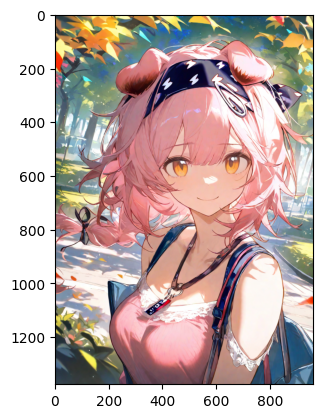

In [23]:
from compel import Compel, ReturnedEmbeddingsType
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import math
import torch, gc
from tqdm import tqdm

def generate_image(pipe, prompt, negative_prompt, output_path, width, height, guidance_scale, guidance_rescale, num_inference_steps, seed):
    """Menghasilkan gambar Stable Diffusion."""
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        seed=seed,
        width=width,
        height=height,
        guidance_scale=guidance_scale,
        guidance_rescale=guidance_rescale,
        target_size=(width, height),
        original_size=(4096, 4096),
        num_inference_steps=num_inference_steps,
        truncation=True
    ).images[0]
    image.save(output_path)
    return image

def log_metadata(file_path, start_num, end_num, output_base, width, height, prompt, negative_prompt, guidance_scale, guidance_rescale, num_inference_steps, elapsed_time):
    """Mencatat metadata ke dalam file teks."""
    with open(file_path, "a") as text_file:
        text_file.write(f"\n\nTITLE: {start_num}--{end_num} {output_base} {width}x{height}px\n + {prompt}\n - {negative_prompt}\n guide scale/rescale: {guidance_scale}/{guidance_rescale}\n steps: {num_inference_steps}\nIt took {math.floor(elapsed_time/60)} minutes {math.floor(elapsed_time%60)} seconds!")

amount = 20 #@param {type:'integer'}
#@markdown ---
char = "(1girl, goldenglow (arknights), arknights (series), sensitive)" #@param {type:"string"}
desc_char = "smirk, seducting expresision, mature teen, medium breast, casual" #@param {type:'string'}
pov = "dutch angle, looking at viewer, from front, depth of field, close up" #@param {type:"string"}
bg = "colorful, outdoors, park, natural scenery" #@param {type:"string"}
style = "very smooth line, masterpiece, high score, absurdres, newest" #@param {type:"string"}
add = "[light particles]" #@param {type:"string"}
#@markdown ---
prompt = f"{char}, {desc_char}, {pov}, {bg}, {style}, {add}"
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry" #@param {type:'string'}
#@markdown ---
W = 960 #@param {type:"slider", min:512, max:2048, step:32}
H = 1376 #@param {type:"slider", min:512, max:2048, step:32}
guidance_scale = 5 #@param {type:'number'}
guidance_rescale = 0.9 #@param {type:'number'}
num_inference_steps = 28 #@param {type:'integer'}
#@markdown ---
outputbase = "/content/anime_girl" #@param {type:'string'}
rand = True #@param {type:'boolean'}
if rand:
  seed = 9999999 #@param {type:'integer'}
startNum = num

start_time = time.time()
array_time = []

for x in tqdm(range(amount), desc="Generating Images"):
    gc.collect()
    torch.cuda.empty_cache()
    image_start_time = time.time()
    if rand:
        set_seed = random.randint(100000, 10000000)
    else:
        set_seed = seed
    output_file = f"{outputbase}{num}_{set_seed}.png"
    image = generate_image(pipe, prompt, negative_prompt, output_file, W, H, guidance_scale, guidance_rescale, num_inference_steps, set_seed)
    plt.imshow(image)
    image_end_time = time.time()
    array_time.append(image_end_time - image_start_time)
    num += 1

end_time = time.time()
total_time = end_time - start_time
log_metadata(f"prompt{prompt_num}.txt", startNum, num - 1, outputbase, W, H, prompt, negative_prompt, guidance_scale, guidance_rescale, num_inference_steps, total_time)

gc.collect()
torch.cuda.empty_cache()

print(f"It took {math.floor(total_time/60)} minutes {math.floor(total_time%60)} seconds!")

In [ ]:
#@title #**2.2 PLAY IMG2IMG SD (COMINGSOON)**
url = ""
init_image = load_image(url).convert("RGB")
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt, image=init_image).images

In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
#@title # +**remove_file(s)**
!rm "/content/"*.png

In [ ]:
!rm f"/content/{outputbase}{num-1}_{setseed}.png"

In [24]:
#@title #**3.0 CONNECT & SAVE TO GOOGLE DRIVE**
from google.colab import drive
import datetime

drive.mount('/content/drive')

x = datetime.datetime.now().strftime("%Y_%m_%d")
!mkdir "/content/drive/MyDrive/Colab Notebooks/{x}"
!mkdir "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"

!mv "/content/"*.png "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"
!mv "/content/"*.txt "/content/drive/MyDrive/Colab Notebooks/{x}/prompt{prompt_num}"

prompt_num = prompt_num + 1

Mounted at /content/drive


In [ ]:
!mv /content/dir {dir}

In [ ]:
!mkdir outputs

In [ ]:
!mv "/content/"*.png "/content/outputs"

In [ ]:
!smi-nvidia

In [ ]:
#@title #**4.0 AUTOMATE PROMPTING (COMINGSOON)**

class PromptStableDiffusion:
    def __init__(self, subjek, gaya, latar_belakang, detail_tambahan):
        self.subjek = subjek
        self.gaya = gaya
        self.latar_belakang = latar_belakang
        self.detail_tambahan = detail_tambahan

    def buat_prompt(self):
        prompt = f"{self.subjek}, {self.gaya}, latar belakang {self.latar_belakang}, {self.detail_tambahan}"
        return prompt

prompt1 = PromptStableDiffusion(
    subjek="seorang wanita muda",
    gaya="lukisan cat minyak impresionis",
    latar_belakang="taman bunga matahari yang luas",
    detail_tambahan="matahari terbenam, burung-burung terbang di kejauhan"
)

prompt2 = PromptStableDiffusion(
    subjek="seekor naga raksasa",
    gaya="fantasi gelap",
    latar_belakang="kastil kuno yang hancur",
    detail_tambahan="langit mendung, petir menyambar"
)

daftar_prompt = [prompt1, prompt2]

for prompt_obj in daftar_prompt:
    print(prompt_obj.buat_prompt())



import json
daftar_prompt_json = [prompt_obj.__dict__ for prompt_obj in daftar_prompt]

with open("prompt_stable_diffusion.json", "w") as f:
    json.dump(daftar_prompt_json, f, indent=4)

print("\nPrompt telah disimpan dalam file prompt_stable_diffusion.json")

# **0.0 *~ ARCHIVE*** ~

In [ ]:
#@markdown # Read Glosarium
!git clone https://github.com/FreNzQuiN/GenerativeAI/blob/main/Stable_Diffusion/cheatsheet.md

In [ ]:
#@title #**2.1 PLAY TEXT2IMG SD**
from compel import Compel, ReturnedEmbeddingsType
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import math
import torch, gc

textFile = open(f"prompt{prompt_num}.txt", "a")

amount = 5 #@param {type:'integer'}
prompt = "1girl, goldenglow \(arknights\), arknights \(series\), dutch angle, looking at viewer, cgdct, cute, solo, smile, light particles, casual, beautiful background, blush, outdoors, park, medium breast, from front, depth of field, very smooth line, year 2024, masterpiece, high score, great score, absurdres" #@param {type:'string'}
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry" #@param {type:'string'}
outputbase = "/content/anime_girl" #@param {type:'string'}
startNum = num

# compel = Compel(
#   tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
#   text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
#   returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
#   requires_pooled=[False, True]
# )
# conditioning, pooled = compel(prompt)
W = 1024 #@param {type:'integer'}
H = 1424 #@param {type:'integer'}
guidance_scale = 5 #@param {type:'number'}
guidance_rescale = 0.9 #@param {type:'number'}
num_inference_steps = 28 #@param {type:'integer'}
rand = True #@param {type:'boolean'}
start = time.time()
arrayTime = []

for x in range(amount):
  gc.collect()
  torch.cuda.empty_cache()
  start = time.time()
  if rand == True:
    setseed = random.randint(100000,10000000)
  else:
    seed = 6 #@param {type:'integer'}
    setseed = seed
  image = pipe(
      # prompt_embeds=conditioning, pooled_prompt_embeds=pooled,
      prompt=prompt,
      negative_prompt=negative_prompt,
      seed=setseed,
      width=W,
      height=H,
      guidance_scale=guidance_scale,
      guidance_rescale=guidance_rescale,
      target_size=(W,H),
      original_size=(4096,4096),
      num_inference_steps=num_inference_steps,
      truncation=True
      ).images[0]
  output=f"{outputbase}{num}_{setseed}.png"
  image.save(output)
  image = Image.open(output)
  plt.imshow(image)
  end = time.time()
  length = end - start
  arrayTime.append(length)
  num=num+1

end = time.time()
length = end - start
print("It took", math.floor(length/60), "minutes", math.floor(length%60), "seconds!")
textFile.write(f"\n\nTITLE: {startNum}--{num-1} {outputbase} {W}x{H}px\n + {prompt}\n - {negative_prompt}\n guide scale/rescale: {guidance_scale}/{guidance_rescale}\n steps: {num_inference_steps}\nIt took {math.floor(length/60)} minutes {math.floor(length%60)} seconds!")
textFile.close()
gc.collect()
torch.cuda.empty_cache()